# <center>Entrenar y evaluar una red neuronal convolucional para resolver un problema de clasificación de imágenes</center>

<div style="background-color: #fdebd0 ">
<b>Este TP tiene 3 objetivos:</b><br>
- Describir conceptos vinculados al entrenamiento y uso de <i>ConvNets</i> para la clasificación de imágenes<br>
- Familiarizarse con la librería PyTorch<br>
- Reproducir un protocolo para entrenar una red neuronal convolucional y clasificar imágenes.</div>


PyTorch es una librería de aprendizaje automático de código abierto para Python, desarrollada principalmente por el grupo de investigación de inteligencia artificial de Facebook. Dentro de PyTorch, el paquete <code>torchvision</code> consiste en conjuntos de datos populares, arquitecturas de modelos y transformaciones de imágenes comunes para la visión artificial.

En la primera parte del trabajo práctico, utilizaremos el conjunto de datos CIFAR10 disponible en <code>torchvision</code>.  Este dataset sirve para aprender a resolver un problema de clasificación con 10 clases: 'avión', 'automóvil', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión'. Las imágenes en CIFAR-10 son de tamaño 3x32x32, es decir, imágenes en color de 3 canales de 32x32 píxeles de tamaño: https://www.cs.toronto.edu/~kriz/cifar.html

El código está basado en el tutorial de PyTorch siguiente: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

<img src="cifar10.png"></img>

Para resolver el problema de clasificación de imágenes, seguiremos los siguientes pasos:

- Cargar y normalizar los conjuntos de datos de entrenamiento y pruebas utilizando CIFAR10.
- Configurar una red neuronal de convolución
- Definir una función de pérdida
- Optimizar la red sobre los datos de entrenamiento
- Probar el rendimiento de la red con los datos de test

Por cada paso, se solicita responder a una serie de preguntas.

## 1. Cargar y normalizar el dataset CIFAR10

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

#The output of torchvision datasets are PILImage images of range [0, 1]. 
#We transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


<div style="background-color: #fdebd0 ">
<b>Preguntas</b><br>
1) ¿Cuál es el tamaño del dataset de entrenamiento y del dataset de test? (Imprimir el resultado con la función <code>print</code>)<br>
2) ¿Por qué el parametro <code>shuffle</code> se configura "True" para el dataset de entrenamiento y "False" para el dataset de test? ¿De qué sirve este parametro?<br>


In [4]:
print("El tamaño del dataset de entrenamiento es de: {}".format(len(trainset)))
print("El tamaño del dataset de prueba  es de: {}".format(len(testset)))

El tamaño del dataset de entrenamiento es de: 50000
El tamaño del dataset de prueba  es de: 10000


<b>2) el parametro sirve para indicar si los datos seran revueltos por cada epoch, el parametro debe estar en verdadero para
    <b>

El código siguiente permite mostrar imagenes aleatorias del dataset de entrenamiento y su etiqueta real:

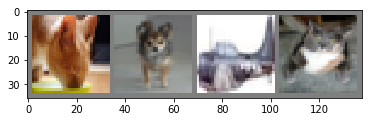

  cat   dog plane   cat


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def imagesFromBatches(iterator,quantity):
    dataiter = iter(iterator)
    images, labels = dataiter.next()    
    imshow(torchvision.utils.make_grid(images))
    print(' '.join('%5s' % classes[labels[j]] for j in range(quantity)))
    return (images,labels)

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Configurar la CNN

In [18]:
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().cuda()

summary(net,(3,32,32))

RuntimeError: Given groups=1, weight of size [12, 6, 5, 5], expected input[2, 16, 5, 5] to have 6 channels, but got 16 channels instead

<div style="background-color: #fdebd0 ">
<b>Preguntas</b><br>
1) ¿Cuántas capas tiene esta ConvNet?<br>
    
R) posee siete capas    
    
2) Explicar los parametros de cada capa. ¿Cuántos filtros se utilizan en las capas de convolución? ¿Cuál es el tamaño de los filtros? <br>

R) 6 filtros de 5x5 en la primera convolucion y 16 de 5x5

3) ¿Cuál es la diferencia entre la función <code>init</code> y <code>forward</code>?<br>

R) init define instrucciones y forward define cual instruccion sigue cual

4) ¿De qué sirve la función view()? Explicar sus parametros.<br>

R) transforma capas a vectores

5) ¿Cuántos paramétros en total se tiene que aprender con esta ConvNet? <br>

R) se tienen que aprender 62,006

6) ¿Por qué se utiliza la función <code>conv2d</code> aunque tenemos imagenes con 3 canales?

R) Porque los canales son una forma de interpretacion de las imagenes 2d

</div>

## 3. Entrenar la CNN

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.cuda() ,labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.225
[1,  4000] loss: 1.849
[1,  6000] loss: 1.660
[1,  8000] loss: 1.578
[1, 10000] loss: 1.506
[1, 12000] loss: 1.432
[2,  2000] loss: 1.380
[2,  4000] loss: 1.362
[2,  6000] loss: 1.331
[2,  8000] loss: 1.300
[2, 10000] loss: 1.264
[2, 12000] loss: 1.257
[3,  2000] loss: 1.162
[3,  4000] loss: 1.172
[3,  6000] loss: 1.159
[3,  8000] loss: 1.176
[3, 10000] loss: 1.138
[3, 12000] loss: 1.153
[4,  2000] loss: 1.060
[4,  4000] loss: 1.065
[4,  6000] loss: 1.087
[4,  8000] loss: 1.053
[4, 10000] loss: 1.059
[4, 12000] loss: 1.057
Finished Training


- Ver la video: https://www.youtube.com/watch?v=ErfnhcEV1O8 - A Short Introduction to Entropy, Cross-Entropy and KL-Divergence

- Leer: http://ruder.io/optimizing-gradient-descent/index.html - An overview of gradient descent optimization algorithm

<div style="background-color: #fdebd0 ">
<b>Preguntas</b><br>
1) ¿Qué hace la función <code>CrossEntropyLoss</code>? Qué devuelve? Con qué otra función se podría reemplazar <code>CrossEntropy</code>?<br>

R) La funcion CrossEntropyLoss permite entregar un criterio que permite saber la lejania del valor real y el valor entregado por el algoritmo, se podria reemplazar con  las nn.LogSoftmax y nn.NLLLoss ya que es una combinación de ambas    
    
2) ¿Cuál es la diferencia principal entre los métodos de optimización Gradient Descent, Stochastic Gradient Descent y Mini-Batch Gradient Descent?<br>

R) 

3) ¿En nuestro ejemplo, qué método utilizamos? En qué parte del código se podría cambiar el tamaño del batch?<br>

R) utilizamos sgd, el tamaño del batch se puede cambiar al comienzo del codigo, al indicar el tamaño de entrenamiento y prueba.

4) ¿Qué metafora podemos utilizar para entender la idea del parametro <code>momentum</code>?<br>

R) On the importance of initialization and momentum in deep learning


5) ¿Podría ser útil aumentar el número de epoch? ¿Por qué? De qué sirve este parametro?

R) Podria ser util ya que a medida que aumente la cantidad de epoch se podria disminuir la función de perdida. Este parametro permite indicar la cantidad de epocas por la que pasa el algoritmo.

</div>

## 4. Evaluar la CNN

Tomamos 4 ejemplos del dataset de test:

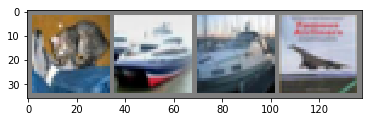

  cat  ship  ship plane


In [10]:
BatchSize=4

images,labels= imagesFromBatches(testloader,BatchSize)
images,labels=images.cuda(),labels.cuda()

Clasificamos estas 4 imágenes con nuestra CNN: 

In [11]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


<div style="background-color: #fdebd0 ">
<b>Pregunta</b><br>
1) ¿Cuál es el rendimiento del modelo entrenado sobre estos primeros ejemplos?
</div>

Calculamos el rendimiento de nuestra CNN sobre todos los datos del training set:

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


Miramos el rendimiento de la CNN calculando su exactitud según cada etiqueta:

In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 44 %
Accuracy of   car : 64 %
Accuracy of  bird : 69 %
Accuracy of   cat : 39 %
Accuracy of  deer : 42 %
Accuracy of   dog : 36 %
Accuracy of  frog : 54 %
Accuracy of horse : 66 %
Accuracy of  ship : 88 %
Accuracy of truck : 37 %


<div style="background-color: #fdebd0 ">
<b>Preguntas:</b><br>
1) ¿Qué paramétros podrían modificar para tratar de mejorar el rendimiento de la CNN? <br>
    
R) Aumentar la cantidad de epocas.    
    
2) ¿Cómo se llama la arquitectura de CNN que hemos utilizado? (ver slides del curso y https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5 y https://adeshpande3.github.io/The-9-Deep-Learning-Papers-You-Need-To-Know-About.html)<br>

R) LeNet-5

3) ¿Qué pasa si tratan de agregar más filtros en la segunda capa de convolución? <br>

R) Aumentan o disminuyen los parametros en funcion del aumento o disminucion de filtros

4) ¿Qué pasa si trata de agregar una tercera capa de convolución y pooling? <br>


R) El codigo no funcionaria

5) ¿En la literatura, qué arquitecturas CNN permiten obtener mejores rendimiento que la arquitectura LeNet-5? Cuál es el limite de estas arquitecturas? <br>

R) GoogleNet,ResNet,ZFNet,AlexNet. El limite de todas estas arquitecturas pueden ser tanto el hardware y el tiempo en el que se ejecuta el entrenamiento

</div>

<div style="background-color: #fdebd0 ">
<b>T.P</b><br>
Optimizar una CNN para resolver el problema asociado al dataset Fashion-MNIST (https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist). <br>

1) ¿La arquitectura LeNet-5 es mejor que Random Forest? Comparar el rendimiento obtenido con lo obtenido por el algoritmo RandomForest (con 50 estimadores).
</div>